# Ditchley S2DS project August 2020 - Pipeline C

## Team: Adam Hawken, Luca Lamoni, Elizabeth Nicholson, Robert Webster

This notebook (C_pipeline) will be dedicated to:
C1: Package and data imports
C2: Hashtag analysis, topic assignment and searching for keywords
C3: Preprocessing for training Doc2Vec model
C4: Training Doc2Vec model and testing robustness
C5: Apply Doc2Vec to tweets and some basic analysis


## Section C1: Package and data imports

### C1.1: Package intallations

In [1]:
# installations an imports

#!pip install gensim==3.8.3
#!pip install wordcloud

import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import difflib
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


In [2]:
# set path for calling functions
sys.path.insert(1, '../')

from src.topics import hashtag_analysis as ha
#import src.plots
from src.topics import preprocessing as pp
from src.topics import topic_modelling as tm

### C1.2: importing data

In [3]:
# import data

src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['tweet_id', 'text', 'hashtags']]], axis=0)
        pbar.update(1)
        
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data = data[data.text != '']

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.34s/it]


## Section C2: Hashtag analysis, topic assignment and keyword searches

### C2.1 Hashtag analysis

In [4]:
# vectorize the hashtags

hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722766 entries, 1 to 87447
Columns: 217116 entries, 00050c to 𝙏𝙐𝙀𝙎𝘿𝘼𝙔𝙏𝙐𝙉𝙀𝙎
dtypes: Sparse[int64, 0](217116)
memory usage: 21.7 MB


9.012709550464738e-06

Sum of the explained variance = 0.189.


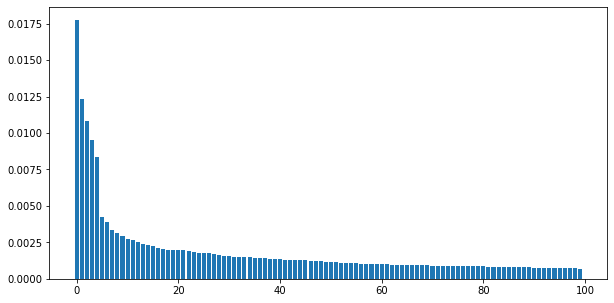

In [5]:
# Use TruncatedSVD on vectorised documents as dimensionality reduction to generate topics.

hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [6]:
# make topic keywords

topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics.head(50)

,keywords
topic,
0,[covid19]
1,"[ai, cybersecurity, fintech]"
2,"[cybersecurity, infosec]"
3,[fintech]
4,[coronavirus]
5,"[infosec, iot, security, tech, technology]"
6,"[bigdata, datascience, machinelearning]"
7,"[infosec, security]"
8,"[iot, privacy, security]"


### C2.2 Topic assignment

In [7]:
# define topics with some human input here is necessary 

topics = [['covid19', 'lockdown', 'coronavirus', 'covid', 'pandemic'], 
['ai', 'ml', 'datascience', 'artificalintelligence', 'data', 'bigdata'], 
['cybersecurity', 'iot', 'robotics', 'infosec', 'cyber'],
['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto'],
['startup', 'startups'],
['malware', 'ransomware'], 
['environment', 'health', 'mentalhealth', 'research', 'wellbeing'],
['beirut', 'belarus', 'lebanon']]

### C2.3 Searching for hashtags or keywords

In [8]:
# run this cell if you want to match the topic list with hashtags 

possible_topics = data['hashtags'].apply(lambda x: ha.check_for_matches(eval(x), topic_list=topics, number_other_topic=10))

labelled_data = data.assign(topic_labels=possible_topics.values)
labelled_data['main_label'] = labelled_data['topic_labels'].apply(lambda x: x[0])
labelled_data

,tweet_id,text,hashtags,topic_labels,main_label
1,1293934001514848256,rt breaking via fbi to join beirut blast probe...,"['breaking', 'fbi', 'beirut', 'probe']",[7],7
2,1293580602055299072,rt breaking lebanon prosecutor to question sev...,"['breaking', 'beirutblast']",[10],10
6,1292021027543953408,rt according to the lebanese health ministry o...,['beirutblast'],[10],10
9,1291401752911257606,rt breaking imf urges lebanon to break reform ...,"['breaking', 'lebanon']",[7],7
12,1291331749956509698,macron says will pitch new political deal to l...,['lebanon'],[7],7
...,...,...,...,...,...
87365,1270406159355334656,rt another fascinating panel this afternoon th...,"['trust', 'technology']",[10],10
87379,1268578990220029953,rt join this cogx panel to hear the latest exp...,['cogx2020'],[10],10
87437,1260516465435906050,rt join us today bst to discuss whether a join...,"['covid19uk', 'contacttracing']",[10],10
87439,1260119164502659072,rt could ai get us out of lockdown a group of ...,['ai'],[1],1


In [9]:
flat_topics = list(set([item for sublist in topics for item in sublist]))

In [28]:
# import data, this time finding matched for keywords

src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data_new= pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df['text'] = df['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
        df['keywords'] = df['text'].apply(lambda x: ha.check_keyword_matches(x, flat_topics))
        df = df[df['keywords'].astype(str)!='[]']
        data_new = pd.concat([data_new, df[['tweet_id', 'text', 'hashtags', 'keywords']]], axis=0, ignore_index=True)
        pbar.update(1)
        
data_new = data_new[data_new.text != '']

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [01:56<00:00,  2.90s/it]


In [30]:
# this is the cell to run if you want to match topics to keywords

labelled_data['topic_labels'] = data_new['keywords'].apply(lambda x: ha.check_for_matches(x, topics, 10))
labelled_data['main_label'] = labelled_data['topic_labels'].apply(lambda x: x[0] if len(x)>0 else -1)
labelled_data

,tweet_id,text,hashtags,topic_labels,main_label
1,1293934001514848256,rt breaking via fbi to join beirut blast probe...,"['breaking', 'fbi', 'beirut', 'probe']",[7],7
2,1293580602055299072,rt breaking lebanon prosecutor to question sev...,"['breaking', 'beirutblast']",[7],7
6,1292021027543953408,rt according to the lebanese health ministry o...,['beirutblast'],[7],7
9,1291401752911257606,rt breaking imf urges lebanon to break reform ...,"['breaking', 'lebanon']",[7],7
12,1291331749956509698,macron says will pitch new political deal to l...,['lebanon'],[7],7
...,...,...,...,...,...
87365,1270406159355334656,rt another fascinating panel this afternoon th...,"['trust', 'technology']","[0, 2, 5]",0
87379,1268578990220029953,rt join this cogx panel to hear the latest exp...,['cogx2020'],"[1, 5]",1
87437,1260516465435906050,rt join us today bst to discuss whether a join...,"['covid19uk', 'contacttracing']",[2],2
87439,1260119164502659072,rt could ai get us out of lockdown a group of ...,['ai'],"[0, 2, 5]",0


In [31]:
# to give an idea about how many tweets are in each topic: 
labelled_data.groupby('main_label').count()

,tweet_id,text,hashtags,topic_labels
main_label,,,,
0,315379,315379,315379,315379
1,136686,136686,136686,136686
2,85857,85857,85857,85857
3,28383,28383,28383,28383
4,25578,25578,25578,25578
5,17576,17576,17576,17576
6,77306,77306,77306,77306
7,36001,36001,36001,36001


In [33]:
# produce a random sample of topics to train the model with
sample_df = ha.produce_random_sample(labelled_data, labelled_data['main_label', 5000])

AttributeError: module 'src.topics.hashtag_analysis' has no attribute 'produce_random_sample'

In [ ]:
# grouping by label and joining the tweets together to prepare for wordcloud plot
grouped = sample_df.groupby('main_label')['text'].agg(' '.join)

In [ ]:
# plotting a wordcloud of first topic
plots.wordcloud_plot(grouped[0])

## C3: Preprocessing for training Doc2Vec model
A lot of code adapted from Martin's script ref: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [ ]:
# preprocessing the tweets for training (no stopword removal since Doc2Vec likes the context for semantic relations)

min_characters_sent = 3   #Min characters in a sentence (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

labelled_data['tokens'] = labelled_data['text'].apply(lambda x: pp.tokenize_text(str(x)), min_characters_word)


In [ ]:
train, test = train_test_split(labelled_data[['text', 'main_label', 'tokens']], test_size=test_size, random_state=42)

train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)

## C4: Training Doc2Vec model and testing robustness 
### C4.1: distributed bag of words (dbow)

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=1, min_count=2, sample=0, workers=cores) #My optimised values

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
y_train, X_train = tm.vec_for_learning(model_dbow, train_tagged)
y_test, X_test = tm.vec_for_learning(model_dbow, test_tagged)

logreg_dbow = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dbow.fit(X_train, y_train)
y_pred = logreg_dbow.predict(X_test)

print('model_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

### C4.2: distributed memory (dmm)

In [ ]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [ ]:
y_train, X_train = tm.vec_for_learning(model_dmm, train_tagged)
y_test, X_test = tm.vec_for_learning(model_dmm, test_tagged)

logreg_dmm = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dmm.fit(X_train, y_train)
y_pred = logreg_dmm.predict(X_test)

print('model_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

### C4.3: combined pairing

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
# Model Pairing method

y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)

logreg_new = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)

print('model_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

### C4.4: Testing the model makes sense

In [ ]:
sim = model_dmm.n_similarity(['covid'], ['coronavirus'])
sim2 = model_dmm.n_similarity(['coronavirus'], ['pandemic'])
sim3 = model_dmm.n_similarity(['coronavirus'], ['cybersecurity'])
sim4 = model_dmm.n_similarity(['cybersecurity'], ['trump'])

print("{:.4f}".format(sim))
print("{:.4f}".format(sim2))
print("{:.4f}".format(sim3))
print("{:.4f}".format(sim4))

In [ ]:
similar_words = model_dmm.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
similar_words

In [ ]:
similar_words = model_dmm.most_similar(positive=['cryptocurrency', 'phishing'], negative=['security'], topn=3)
similar_words

In [ ]:
similar_words = model_dmm.most_similar(positive=['media', 'trump'], negative=['safety'], topn=3)
similar_words

## C5: Apply Doc2Vec model to tweets and some basic analysis
### C5.1: apply doc2vec to tweets

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
classifier_model = logreg_dbow
model = model_dbow

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: tm.clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=tm.tokenize_text(r['clean_tweet']), tags=[r.screen_name]), axis=1)
        X_test = tm.get_vectors_apply(model, test_tagged)
        df['y_pred'] = classifier_model.predict(X_test)
        y_pred_score = classifier_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=classifier_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv('tweets_trained_topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv('tweets_trained_all_topics_modelled_'+str(i)+'.csv', index=False)
        print(df4.head())
        pbar.update(1)
        i = i+1

### C5.2: How are user's tweets spread over topics?

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\S2DS\tweets_trained_all_topics_10'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dbow.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

list(df_totalled_topics)

In [ ]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby('screen_name')['0', '1', '10', '2', '3', '4', '7', '8', '9'].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df1])
        pbar.update(1)
df_totalled_topics.head()


In [ ]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)
df2 = df_totalled_topics[['0', '1', '10', '2', '3', '4', '7', '8', '9']].div(df_totalled_topics.total, axis=0)
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'user_name'})
df2.columns = ['user_name', 'Covid19', 'A.I.', 'Other', 'Cybersecurity', 'Financial tech/cyrptocurrency', 'Startup', 'malware', 'environment', 'beirut']

In [ ]:
df2.to_csv('user_name_topics_summed_10.csv', index=False)

In [ ]:
df3 = df2.set_index('user_name')

In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))

In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.loc['gcluley']
row1.plot(kind='bar',title='gcluley', color='r',stacked=False, figsize=(15,5))

### C5.3: Who is the maximum tweeter in each topic?

In [ ]:
print(df3['Covid19'].idxmax(), )
print(df3['A.I.'].idxmax(), )
print(df3['Cybersecurity'].idxmax(), )
print(df3['Financial tech/cyrptocurrency'].idxmax(), )

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Other', 'Cybersecurity', 'Financial tech/cyrptocurrency', 'Startup', 'malware', 'environment', 'beirut']
row1 = df3.loc['fuckkgirl_ck']
fig = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
fig.set_ylabel('Topics', fontsize=30)
fig.set_xlabel('Proportion of tweets', fontsize=30)
fig.set_yticklabels(labels, fontsize=20)
fig.set_xticklabels(xlabels, fontsize=20)
fig.set_title('fuckkgirl_ck', fontsize = 30 )
fig.figure.savefig('fuckkgirl_ck.png')